In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cd ../src

/workspace/kaggle_rsna_lumbar_spine/src


In [3]:
import os
import cv2
import json
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from collections import Counter
from tqdm.notebook import tqdm


pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)

In [4]:
from params import *

from data.preparation import *
from data.dataset import *
from data.transforms import get_transfos

from util.plots import *
from util.logger import Config
from util.torch import load_model_weights

from model_zoo.models_seg import define_model

In [5]:
# prepare_folds()

In [53]:
df = prepare_data_crop(DATA_PATH)  # , crop_folder="../input/crops_fix/")

In [54]:
df = prepare_data_nfn(DATA_PATH, explode=False)

In [93]:
# df = prepare_data_ss_crop(crop_folder="../input/crops_fix/")

In [94]:
df = prepare_data_scs(DATA_PATH, crop_folder="../input/crops_fix/")

In [101]:
df_preds_coords = pd.read_csv('../output/seg_sag_coords.csv')
df = df.merge(df_preds_coords, how="left")
df['coords_2'] = df.apply(
    lambda x: [{"Left": x.left, "Right": x.right, "Center": x.center}[x.side]],
    axis=1
)

In [102]:
err = df.apply(lambda x: x.coords_2[0] - x.coords[0], axis=1)

In [108]:
df[err.abs() > 4]

,study_id,series_id,series_description,orient,weighting,img_path,condition,level,coords,target,side,left,center,right,mid,coords_2
938,404602713,1230697721,Sagittal T2/STIR,Sagittal,T2/STIR,../input/crops_fix/404602713_1230697721_l5_s1.npy,Spinal Canal Stenosis,L5/S1,"[6.0, 177.29936563351498, 230.9080301643392]",0,Center,13,11,7,10,[11]
1156,504362668,4031652250,Sagittal T2/STIR,Sagittal,T2/STIR,../input/crops_fix/504362668_4031652250_l4_l5.npy,Spinal Canal Stenosis,L4/L5,"[15.0, 477.2274368231047, 489.01083032490976]",0,Center,13,9,6,11,[9]
1157,504362668,4031652250,Sagittal T2/STIR,Sagittal,T2/STIR,../input/crops_fix/504362668_4031652250_l5_s1.npy,Spinal Canal Stenosis,L5/S1,"[15.0, 502.1805054151625, 541.6895306859207]",0,Center,13,9,6,11,[9]
3665,1647904243,429524619,Sagittal T2/STIR,Sagittal,T2/STIR,../input/crops_fix/1647904243_429524619_l5_s1.npy,Spinal Canal Stenosis,L5/S1,"[8.0, 142.9517543859649, 168.8421052631579]",0,Center,12,13,15,13,[13]
6667,2937953357,2433869833,Sagittal T2/STIR,Sagittal,T2/STIR,../input/crops_fix/2937953357_2433869833_l1_l2.npy,Spinal Canal Stenosis,L1/L2,"[1.0, 211.01769911504425, 129.15929203539824]",0,Center,13,10,7,10,[10]
7461,3294654272,4147986695,Sagittal T2/STIR,Sagittal,T2/STIR,../input/crops_fix/3294654272_4147986695_l1_l2.npy,Spinal Canal Stenosis,L1/L2,"[0.0, 161.77150632022472, 270.5056179775281]",0,Center,14,9,7,10,[9]
7910,3480975258,571488072,Sagittal T2/STIR,Sagittal,T2/STIR,../input/crops_fix/3480975258_571488072_l5_s1.npy,Spinal Canal Stenosis,L5/S1,"[14.0, 324.7485822306238, 461.9432892249527]",0,Center,13,9,6,11,[9]
9240,4072191052,2094081979,Sagittal T2/STIR,Sagittal,T2/STIR,../input/crops_fix/4072191052_2094081979_l5_s1.npy,Spinal Canal Stenosis,L5/S1,"[11.0, 262.9829913147139, 277.11451060115803]",0,Center,9,6,4,9,[6]


In [103]:
np.abs(err.values).mean()

0.44706606483381206

In [104]:
((np.abs(err.values) > 5) * 100).mean()

0.04103405826836274

In [105]:
((np.abs(err.values) > 5) * 100).mean()

0.04103405826836274

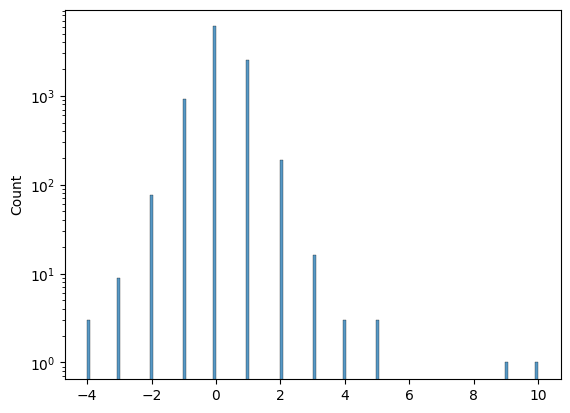

In [100]:
sns.histplot(x=err.values)
plt.yscale('log')

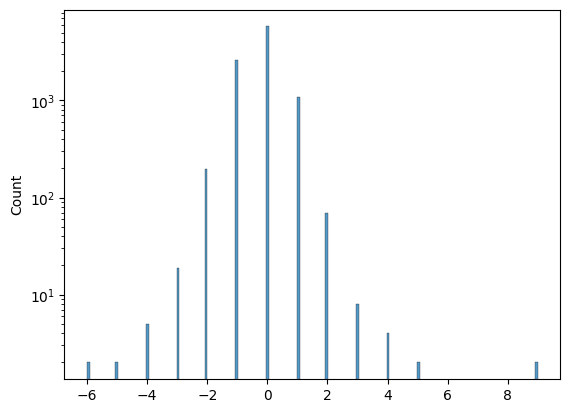

In [106]:
sns.histplot(x=err.values)
plt.yscale('log')

In [ ]:
# df = prepare_data_ss(explode=True)

In [168]:
# img = np.load("../input/npy/10728036_142859125.npy")
# img2 = np.load("../input/npy/10728036_2073726394.npy")
# for i in range(0, len(img), 10):
#     plt.figure(figsize=(5, 5))
#     plt.imshow(img[i], cmap="gray")
#     plt.axis(False)
#     plt.show()

In [169]:
# df[df[CLASSES_SS_NOLVL].sum(1) < 0]

In [170]:
# df[df['target'].apply(len) != 2]

In [171]:
# df = prepare_data_scs(DATA_PATH, explode=False)
# plt.figure(figsize=(20, 5))
# for i, c in enumerate(CLASSES_SCS):
#     plt.subplot(1, len(CLASSES_SCS), i + 1)
#     sns.countplot(x=df[c])
# plt.show()

In [172]:
df = prepare_data_scs(DATA_PATH, "../input/crops_2/")

df = prepare_data_nfn(DATA_PATH, "../input/crops_2/")

In [173]:
df.head(1)

,study_id,series_id,series_description,orient,weighting,img_path,condition,level,coords,side,target,coords_crop
0,4003253,1054713880,Sagittal T1,Sagittal,T1,../input/crops_2/4003253_1054713880_l1_l2.npy,Left Neural Foraminal Narrowing,L1/L2,"[10.0, 196.07067137809187, 126.02120141342756]",Left,0,"[7, 37, 20]"


In [174]:
# df[df["coords_crop"].apply(np.sum) < 0]

In [175]:
# df = prepare_data_scs(DATA_PATH, None, explode=False)
df = prepare_data_nfn(DATA_PATH, None, explode=False, left_right=True)

In [176]:
df[df.isna().sum(1) > 0]

,study_id,series_id,series_description,orient,weighting,img_path,condition,level,coords,neural_foraminal_narrowing_l1_l2,neural_foraminal_narrowing_l2_l3,neural_foraminal_narrowing_l3_l4,neural_foraminal_narrowing_l4_l5,neural_foraminal_narrowing_l5_s1,side


### Dataset

In [208]:
# transfos = get_transfos(augment=False, resize=(384, 384), crop=False)
transfos = get_transfos(augment=False, resize=(224, 224), crop=False)

In [209]:
# df = prepare_data_ss(explode=True)

# dataset = ImageDataset(
#     df,
#     CLASSES_SS_NOLVL,
#     transforms=transfos,
#     frames_chanel=1,
#     n_frames=1,
#     stride=1,
#     train=True,
#     load_in_ram=False,
# )

In [210]:
# df = prepare_data_nfn(DATA_PATH, None, explode=False, left_right=True)

# dataset = ImageDataset(
#     df,
#     CLASSES_NFN_NOSIDE,
#     transforms=transfos,
#     frames_chanel=1,
#     n_frames=1,
#     stride=1,
#     train=True,
#     load_in_ram=False,
# )

In [211]:
# df = prepare_data_nfn(DATA_PATH, "../input/coords_crops_0.1_2/")
# df["img_path_ax"] = df["img_path"].apply(lambda x: "../input/crops_ax_0.15/" + x.split('/')[-1])


# dataset = CropSagAxDataset(
#     df,
#     "target",
#     transforms=transfos,
#     frames_chanel=0,
#     n_frames=3,
#     stride=1,
#     train=True,
#     load_in_ram=False,
#     use_coords_crop=True
# )

In [239]:
# # # df = prepare_data_scs(DATA_PATH, "../input/crops_fix/")
# # df = prepare_data_crop(DATA_PATH, crop_folder="../input/crops_fix/")
# df = prepare_data_nfn(DATA_PATH, "../input/crops_fix/")
# df = prepare_data_nfn(DATA_PATH, "../input/coords_crops_0.15_2/")
# df = prepare_data_ss_crop(DATA_PATH, crop_folder="../input/crops_ax_0.15/")
df = prepare_data_crop(DATA_PATH, crop_folder="../input/coords_crops_0.1_2/")

dataset = CropDataset(
    df,
    "target",
    transforms=transfos,
    frames_chanel=0,
    n_frames=3,
    stride=1,
    train=True,
    load_in_ram=False,
    use_coords_crop=True,
    flip=True
)

In [240]:
for i in tqdm(range(len(dataset))):
    x, y, y_aux = dataset[i]
    # break
    # print(y_aux)

    # if i >= 10:
    break

  0%|          | 0/19770 [00:00<?, ?it/s]

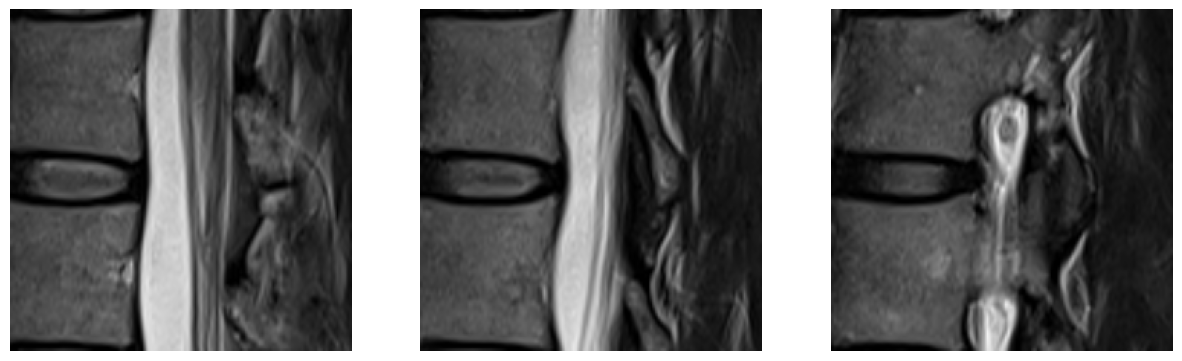

In [241]:
x, y, y_aux = dataset[0]
# x = x['ax']

try:
    img = x.numpy().transpose(0, 2, 3, 1)

    plt.figure(figsize=(15, 5))
    for f in range(len(img)):
        plt.subplot(1, len(img), f + 1)
        plt.imshow(img[f])
        plt.axis(False)
    plt.show()

except:
    img = x.numpy().transpose(1, 2, 0)
    plt.figure(figsize=(15, 5))
    plt.imshow(img)
    plt.axis(False)
    plt.show()

### Model

In [242]:
from model_zoo.models import define_model
from util.torch import count_parameters

In [291]:
model = define_model(
    "coatnet_1_rw_224",  # "coatnet_rmlp_2_rw_384",  # "coatnet_1_rw_224", eva02_small_patch14_224
    pooling="avg",
    head_3d="lstm_side",
    n_frames=3,
    num_classes=15,
    n_channels=3,
    drop_rate=0.,
    reduce_stride=False,
)

In [292]:
count_parameters(model)

45396933

In [293]:
x, y, _ = dataset[19]
x = x.unsqueeze(0)

In [294]:
y[-1] = 0

In [295]:
y

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 0.]])

In [296]:
pred, _ = model(x)

In [297]:
pred.size()

torch.Size([1, 15])

In [300]:
from training.losses import SeriesLoss

loss = SeriesLoss(weighted=True)

loss(pred, y.unsqueeze(1))

tensor([1.0676, 2.1359, 1.1124, 1.0252, 0.0000], grad_fn=<DivBackward0>)

### Inf

In [ ]:
from inference.lvl1 import *

In [ ]:
EXP_FOLDER = "../logs/2024-08-04/33/"


In [ ]:
df = prepare_data_scs(DATA_PATH, explode=False)

In [ ]:
# kfold_inference(df, EXP_FOLDER, batch_size=16, debug=True, save=True, use_fp16=True)

In [ ]:
EXP_FOLDER = "../logs/2024-08-05/27/"

In [ ]:
df = prepare_data_nfn(DATA_PATH, explode=False)

In [ ]:
# kfold_inference(df, EXP_FOLDER, batch_size=16, debug=True, save=False, use_fp16=True, left_right=True)

In [ ]:
EXP_FOLDER = "../logs/2024-08-06/15/"

In [ ]:
df = prepare_data_ss(DATA_PATH, explode=False)

#### Crop models

In [ ]:
# p = kfold_inference(df, EXP_FOLDER, batch_size=16, debug=True, save=True, use_fp16=True, use_aux=True)

In [ ]:
# EXP_FOLDER = "../logs/2024-08-07/19/"
# df = prepare_data_scs(DATA_PATH, "../input/crops_fix/")

# EXP_FOLDER = "../logs/2024-08-07/32/"
# df = prepare_data_nfn(DATA_PATH, "../input/crops_fix/")


EXP_FOLDER = "../logs/2024-08-21/8/"
df = prepare_data_crop(DATA_PATH, "../input/crops_fix/")

if "fold" not in df.columns:
    folds = pd.read_csv("../input/folds_4.csv")
    df = df.merge(folds, how="left")
    df_val = df[df['fold'] == 0].reset_index(drop=True)

In [ ]:
p = kfold_inference_crop(df, EXP_FOLDER, batch_size=16, debug=True, save=True, use_fp16=True)

In [ ]:
# from util.metrics import disk_auc

# pred_inf = np.load(EXP_FOLDER + "preds_inf_0.npy")
# pred_inf2 = np.load(EXP_FOLDER + "pred_inf_0.npy")
# pred_val = np.load(EXP_FOLDER + "pred_val_0.npy")

# print("DELTAS")

# print(np.abs(pred_inf - pred_val).max())
# print(np.abs(pred_inf - pred_inf2).max())
# print(np.abs(pred_val - pred_inf2).max())

# print('AUCS')

# print(
#     disk_auc(df_val["target"].values, pred_val)
# )
# print(
#     disk_auc(df_val["target"].values, pred_inf2)
# )
# print(
#     disk_auc(df_val["target"].values, pred_inf)
# )

### Eval

In [ ]:
df = prepare_data()

In [ ]:
df_train = pd.read_csv(DATA_PATH + "train.csv")
for c in df_train.columns[1:]:
    df_train[c] = df_train[c].map(dict(zip(SEVERITIES, [0, 1, 2]))).fillna(-1)
df_train = df_train.astype(int)
df_train = df_train.set_index("study_id")

In [ ]:
for col in df_train.columns:
    c = dict(Counter(df_train[col].values))
    print(col, "\t", c[0], c[1], c[2])

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
EXP_FOLDER_NFN = "../logs/2024-08-05/27/"

EXP_FOLDER_SCS = "../logs/2024-08-04/33/"

EXP_FOLDER_SS = "../logs/2024-08-06/17/"

In [ ]:
all_preds, all_truths = [], []
for study, df_study in tqdm(df.groupby('study_id')):
    # Get study
    try:
        series_scs = df_study.set_index("series_description")['series_id']['Sagittal T2/STIR']
    except:
        continue  # TODO: fix

    try:
        series_nfn = df_study.set_index("series_description")['series_id']['Sagittal T1']
    except:
        continue  # TODO: fix

    try:
        series_ss = df_study.set_index("series_description")['series_id']['Axial T2']
    except:
        continue  # TODO: fix

    # Load
    try:
        preds_scs = np.load(EXP_FOLDER_SCS+ f'preds/{study}_{series_scs}.npy')
    except:
        preds_scs = np.mean(
            [np.load(EXP_FOLDER_SCS + f'preds/{study}_{s}.npy') for s in series_scs.values], 0
        )
    try:
        preds_nfn = np.load(EXP_FOLDER_NFN + f'preds/{study}_{series_nfn}.npy')
    except:
        preds_nfn = np.mean(
            [np.load(EXP_FOLDER_NFN + f'preds/{study}_{s}.npy') for s in series_nfn.values], 0
        )

    try:
        preds_ss = np.load(EXP_FOLDER_SS + f'preds/{study}_{series_ss}.npy')
        preds_ss_aux = np.load(EXP_FOLDER_SS + f'preds_aux/{study}_{series_ss}.npy')
    except:
        preds_ss = np.mean(
            [np.load(EXP_FOLDER_SS + f'preds/{study}_{s}.npy') for s in series_ss.values[:1]], 0
        )
        preds_ss_aux = np.mean(
            [np.load(EXP_FOLDER_SS + f'preds_aux/{study}_{s}.npy') for s in series_ss.values[:1]], 0
        )

    assert preds_nfn.min() >= 0
    assert preds_ss.min() >= 0
    assert preds_scs.min() >= 0

    # Aggregate preds
    preds = {}
    for i, c in enumerate(CLASSES_SCS):
        p = preds_scs[:, i].max(0)
        # p[0] = 1 - p[1] - p[2]
        p = np.array(p) / np.sum(p)
        preds[c] = p
        
        assert np.min(p) >= 0

    for i, c in enumerate(CLASSES_NFN_NOSIDE):
        p_right = preds_nfn[:len(preds_nfn) // 2, i].max(0)
        # p_right[0] = 1 - p_right[1] - p_right[2]
        p_right = np.array(p_right) / np.sum(p_right)

        p_left = preds_nfn[len(preds_nfn) // 2:, i].max(0)
        # p_left[0] = 1 - p_left[1] - p_left[2]
        p_left = np.array(p_left) / np.sum(p_left)

        preds[f"right_{c}"] = p_right
        preds[f"left_{c}"] = p_left

        assert np.min(p_left) >= 0
        assert np.min(p_right) >= 0

    for i, c in enumerate(CLASSES_SS_NOLVL):
        for lv, lvl in enumerate(LEVELS_):
            p = (preds_ss[:, i] * preds_ss_aux[:, lv][:, None]).max(0)
            p = np.array(p) / np.sum(p)
            p[0] = 1 - p[1] - p[2]
            preds[c + "_" + lvl] = p

    y = df_train.loc[study].to_dict()

    all_preds.append(preds)
    all_truths.append(y)
    # break

df_preds = pd.DataFrame(all_preds)
df_gt = pd.DataFrame(all_truths)

In [ ]:
losses = {}
for c in df_preds.columns:
    aucs = []

    preds = np.vstack(df_preds[c].values)
    y = df_gt[c].values

    preds = preds[y > -1]
    y = y[y > -1]

    # Rescale with loss weights
    # model = LogisticRegression(C=100, class_weight={0: 1, 1:2, 2: 4}, fit_intercept=False, random_state=0)
    model = LogisticRegressionCV(Cs=[1, 10, 100], class_weight={0: 1, 1:2, 2: 4}, fit_intercept=False, random_state=0)
    preds = np.ones((len(y), 3))
    model.fit(preds, y)
    preds = model.predict_proba(preds)

    for i in range(3):
        auc = roc_auc_score(y == i, preds[:, i])
        aucs.append(auc)

    loss = log_loss(
        y,
        preds,
        sample_weight=2 ** y,
        labels=[0, 1, 2],
    )
    
    print(f'-> {c} \n - AUC:  {np.mean(aucs) :.3f} \n - Loss: {loss:.3f}\n')
    losses[c] = loss

In [ ]:
losses_agg = {}

severe_spinal_preds, severe_spinal_gts = [], []
for c in CLASSES_SCS:
    severe_spinal_preds.append(np.vstack(df_preds[c].values)[:, 2])
    severe_spinal_gts.append(df_gt[c].values)

severe_spinal_preds = np.max(severe_spinal_preds, 0)
severe_spinal_gts = np.max(severe_spinal_gts, 0).astype(int)
auc = roc_auc_score(severe_spinal_gts == 2, severe_spinal_preds)

loss = log_loss(
    severe_spinal_gts == 2,
    severe_spinal_preds,
    sample_weight=2 ** severe_spinal_gts,
    labels=[0, 1],
)

losses_agg["any_severe_spinal"] = loss
print(f'-> any_severe_spinal \n - AUC:  {auc :.3f} \n - Loss: {loss:.3f}\n')

In [ ]:
for s in ["spinal_canal_stenosis", "neural_foraminal_narrowing", "subarticular_stenosis"]:
    losses_agg[s] = np.mean([losses[k] for k in losses if s in k])

    print(f'-> Loss - {s} \t: {losses_agg[s] :.3f}\n')

In [ ]:
print(f'\n-> CV loss: {np.mean(list(losses_agg.values())):.3f}')

In [ ]:
from util.metrics import rsna_loss

preds = []
for c in df_gt.columns:
    p = np.vstack(df_preds[c].values)[:, None]
    # print(c, p.min(), p.max())
    preds.append(p)
preds = np.concatenate(preds, 1)

rsna_loss(df_gt.values, preds)

Done ! 